In [1]:
import pandas as pd
import numpy as np
from toolz.curried import *
import tensorflow as tf
from qrnn.data_preprocess import *
from qrnn.pipeline import pipeline
from qrnn.models import qrnn_learner
from qrnn.evaluation import *

from matplotlib import pyplot as plt
plt.style.use("ggplot")

@curry
def fill_nan(dataset, method="ffill"):
    return dataset.fillna(method=method)

N_LAGS=14
PRICE_COLS = ["sp500", "aapl", "ford", "googl", "gs", "msft"]

Using TensorFlow backend.


In [2]:
from toolz import reduce
sp500  = pd.read_csv('../src/qrnn/resources/SP500.csv').rename(columns={"price": "sp500"})
aapl  = pd.read_csv('../src/qrnn/resources/AAPL.csv').rename(columns={"price": "aapl"})
ford  = pd.read_csv('../src/qrnn/resources/FORD.csv').rename(columns={"price": "ford"})
googl  = pd.read_csv('../src/qrnn/resources/GOOGL.csv').rename(columns={"price": "googl"})
gs  = pd.read_csv('../src/qrnn/resources/GS.csv').rename(columns={"price": "gs"})
msft  = pd.read_csv('../src/qrnn/resources/MSFT.csv').rename(columns={"price": "msft"})

data = reduce((lambda df1, df2: df1.merge(df2, "left")), [sp500, aapl, ford, googl, gs, msft])
data.loc[16800, ["aapl", "ford", "googl", "gs", "msft"]] = 0
data.tail()

,date,sp500,aapl,ford,googl,gs,msft
16800,1950-01-09,17.08,0.0,0.0,0.0,0.0,0.0
16801,1950-01-06,16.98,NaN,NaN,NaN,NaN,NaN
16802,1950-01-05,16.93,NaN,NaN,NaN,NaN,NaN
16803,1950-01-04,16.85,NaN,NaN,NaN,NaN,NaN
16804,1950-01-03,16.66,NaN,NaN,NaN,NaN,NaN


In [3]:
differ_learner = diff_log_pricer(price_columns=PRICE_COLS, date_column="date")
lagger_learner = lagger(n_lags=N_LAGS, price_columns=PRICE_COLS)
na_fill_learner = fill_nan(method="ffill")
na_clean_learner = clean_nan(how="any")

In [4]:
pipe_learner = pipeline(learners=[na_fill_learner, differ_learner, lagger_learner, na_clean_learner])
processed_data = pipe_learner(data)
processed_data.tail()

/Users/matheusfacure/Documents/QRNN/src/qrnn/data_preprocess.py:52: RuntimeWarning: divide by zero encountered in log
  log_fn = lambda df: df.assign(**{col: np.log(df[col]) for col in price_columns})


,aapl,aapl1,aapl10,aapl11,aapl12,aapl13,aapl14,aapl2,aapl3,aapl4,...,sp50013,sp50014,sp5002,sp5003,sp5004,sp5005,sp5006,sp5007,sp5008,sp5009
16786,-1.172876,-0.008816,-0.469928,0.425685,0.044243,0.740291,0.149145,-0.017601,0.937901,-1.680431,...,0.048144,-0.325879,1.085800,0.647875,-0.575329,-0.862485,0.642350,0.528258,-0.936513,0.793639
16787,-0.008816,-0.017601,0.425685,0.044243,0.740291,0.149145,1.729652,0.937901,-1.680431,0.150726,...,-0.325879,0.459533,0.647875,-0.575329,-0.862485,0.642350,0.528258,-0.936513,0.793639,-0.326602
16788,-0.017601,0.937901,0.044243,0.740291,0.149145,1.729652,0.215202,-1.680431,0.150726,0.185862,...,0.459533,-1.252458,-0.575329,-0.862485,0.642350,0.528258,-0.936513,0.793639,-0.326602,-0.496788
16789,0.937901,-1.680431,0.740291,0.149145,1.729652,0.215202,0.890266,0.150726,0.185862,0.757587,...,-1.252458,0.114593,-0.862485,0.642350,0.528258,-0.936513,0.793639,-0.326602,-0.496788,0.428749
16790,-1.680431,0.150726,0.149145,1.729652,0.215202,0.890266,-0.307275,0.185862,0.757587,-1.565517,...,0.114593,-0.310408,0.642350,0.528258,-0.936513,0.793639,-0.326602,-0.496788,0.428749,0.048144


In [5]:
splitter = time_split_dataset(train_start_date="1960-01-01", train_end_date="2010-01-01", holdout_end_date="2016-01-01", date_col="date")
train, test = splitter(processed_data)
train.head()

,aapl,aapl1,aapl10,aapl11,aapl12,aapl13,aapl14,aapl2,aapl3,aapl4,...,sp50013,sp50014,sp5002,sp5003,sp5004,sp5005,sp5006,sp5007,sp5008,sp5009
2511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.245011,0.296714,-0.431461,-0.734442,-0.318817,-1.234479,-0.614441,-0.566570,0.549452,-0.034254
2512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.296714,-1.051169,-0.734442,-0.318817,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,-0.842874
2513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.051169,0.140799,-0.318817,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,-1.076771
2514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.140799,-0.246522,-1.234479,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,-1.076771,-0.349834
2515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246522,-1.045645,-0.614441,-0.566570,0.549452,-0.034254,-0.842874,-1.076771,-0.349834,0.245011


In [6]:
from toolz.curried import *
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras import backend as K
from qrnn.evaluation import quantile_loss_evaluator

def qrnn_learner(dataset, price_cols, target_col, target_lag, prediction_col="prediction",
                 tau=0.05, neurons=20, lr=1e-4, batch_size=512, epochs=5, dropout=0.1,
                 stocastic_pass=100, return_variance=True):
    def to_3D(dataset):
        all_p_columns = pipe(dataset.columns,
                             filter(lambda col: reduce(lambda acc, p_col: acc or col.find(p_col) >= 0,
                                                       price_cols, False)),
                             filter(lambda col: col != target_col),
                             filter(lambda col: not col.endswith(str(target_lag))),
                             list)

        def p(new_data):
            return new_data[all_p_columns].values.reshape(-1,
                                                          int(len(all_p_columns) / len(price_cols)),
                                                          len(price_cols))

        return p, p(dataset)

    def quantile_loss(y_true, y_pred):
        ro = tau - tf.cast(tf.greater(y_pred, y_true), tf.float32)
        return tf.reduce_mean(ro * (y_true - y_pred))

    _3Dnator, x_train = to_3D(dataset)
    y_train = dataset[[target_col]].values
    n_samples, timesteps, n_vars = x_train.shape

    # build model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(timesteps, n_vars), dropout=dropout, recurrent_dropout=dropout))
    model.add(Dense(1, activation=None))
    model.add(Dropout(dropout))
    opt = Adam(lr=lr)
    model.compile(loss=quantile_loss, optimizer=opt)

    # train model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    def p(new_dataset):
        x_new = _3Dnator(new_dataset)
        
        if return_variance:
            predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

            y_hat_mc = np.array([predict_stochastic([x_new, 1]) 
                                 for _ in range(stocastic_pass)]).reshape(-1, x_new.shape[0]).T
        
            y_hat_test_mean = np.mean(y_hat_mc, axis=1)
            y_hat_test_variance = np.var(y_hat_mc, axis=1)
            
            return new_dataset.assign(**{prediction_col: y_hat_test_mean,
                                         prediction_col+"_var": y_hat_test_variance})
        else:
            return new_dataset.assign(**{prediction_col: model.predict(x_new)})

    return p, p(dataset)

In [7]:
var_estimator, train_pred = qrnn_learner(train, price_cols=PRICE_COLS, target_lag=14, neurons=100,
                                         target_col="sp50014", epochs=100, lr=1e-3, dropout=0.15, stocastic_pass=200)
test_pred = var_estimator(test)

In [8]:
test_pred.head()

,aapl,aapl1,aapl10,aapl11,aapl12,aapl13,aapl14,aapl2,aapl3,aapl4,...,sp5002,sp5003,sp5004,sp5005,sp5006,sp5007,sp5008,sp5009,prediction,prediction_var
15097,1.544520,0.172737,4.328793,-1.551212,-1.743752,-5.087098,2.654731,-1.603391,-0.185050,0.662609,...,0.054537,0.399322,0.287758,0.174523,-0.942545,0.829146,0.242349,-1.088213,-1.273828,0.290464
15098,0.172737,-1.603391,-1.551212,-1.743752,-5.087098,2.654731,1.403381,-0.185050,0.662609,-0.886061,...,0.399322,0.287758,0.174523,-0.942545,0.829146,0.242349,-1.088213,1.242215,-1.251149,0.323785
15099,-1.603391,-0.185050,-1.743752,-5.087098,2.654731,1.403381,0.937643,0.662609,-0.886061,-1.143996,...,0.287758,0.174523,-0.942545,0.829146,0.242349,-1.088213,1.242215,-1.065439,-1.491410,0.397091
15100,-0.185050,0.662609,-5.087098,2.654731,1.403381,0.937643,-4.220007,-0.886061,-1.143996,1.400686,...,0.174523,-0.942545,0.829146,0.242349,-1.088213,1.242215,-1.065439,-1.912666,-1.970726,0.784913
15101,0.662609,-0.886061,2.654731,1.403381,0.937643,-4.220007,-3.695293,-1.143996,1.400686,-0.580840,...,-0.942545,0.829146,0.242349,-1.088213,1.242215,-1.065439,-1.912666,-2.238978,-2.208526,1.414055


In [9]:
quantile_eval_fn = quantile_loss_evaluator(predict_col="prediction",
                                           target_col="sp50014",
                                           tau=0.05)

hits_eval_fn = proportion_of_hits_evaluator(predict_col="prediction",
                                                target_col="sp50014")

In [10]:
print("Quantile loss on train %f and test %f sets" % tuple(map(quantile_eval_fn, [train_pred, test_pred])))
print("Number of hits on train %f and test %f sets" % tuple(map(hits_eval_fn, [train_pred, test_pred])))

Quantile loss on train 0.082243 and test 0.127436 sets
Number of hits on train 0.073653 and test 0.095364 sets


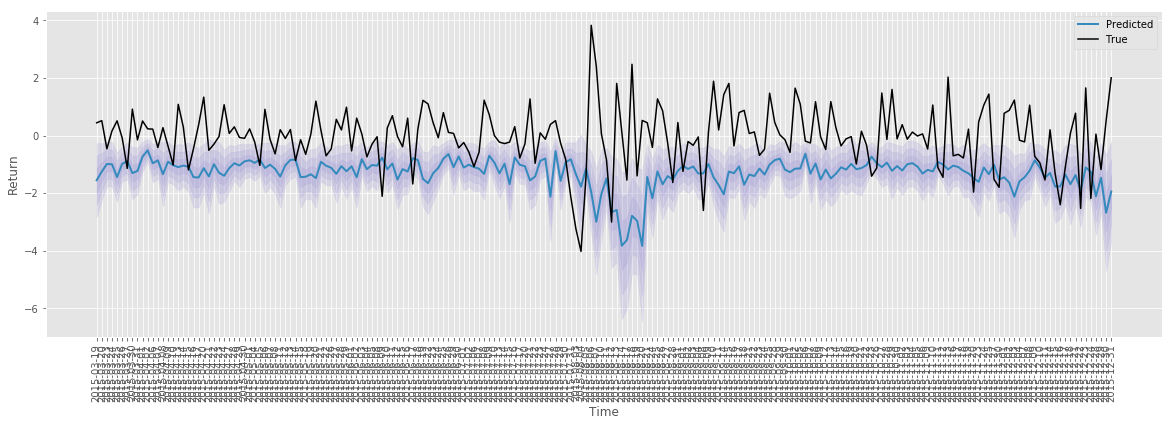

In [14]:
plt.figure(figsize=(20, 6))
n = 200
t = test_pred[["date"]][-n:].values.squeeze()
mu = test_pred[["prediction"]][-n:].values.squeeze()
sigma = np.sqrt(test_pred[["prediction_var"]][-n:]).values.squeeze()
y_true = test_pred[["sp50014"]][-n:].values.squeeze()

plt.style.use("ggplot")
plt.plot(t, mu, label="Predicted", color="C1", lw=2)
plt.plot(t, y_true, color="black", label="True")

for shade in range(1, 4):
    plt.fill_between(t, mu + (sigma*shade*0.5), mu - (sigma*shade*0.5), alpha=0.2, color="C2")

plt.ylabel("Return")
plt.xlabel("Time")
plt.legend(loc="best")
plt.xticks(rotation=90)
plt.savefig("Caviar_RNN.png")
plt.show()